# X-Ray Image Classification

## Import Modules and Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import re
import os 
import urllib.request
import random
import pickle
import boto3
from PIL import Image
from glob import glob
from copy import deepcopy

#Sci-Kit Learn Modules
from skimage import color
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score, accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix 
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

#Tensorflow Modules
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.compat.v1 import set_random_seed

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import models, metrics 
from tensorflow.keras.applications import imagenet_utils, ResNet50V2, ResNet101V2, ResNet152V2, VGG19 
from tensorflow.keras.models import Sequential, Model, load_model, 
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.layers import Activation, BatchNormalization, UpSampling2D, Dropout, Flatten, Dense 
from tensorflow.keras.layers import Input, ReLU, LeakyReLU, Conv2DTranspose, AveragePooling2D, Concatenate

from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.initializers import he_normal, he_uniform, glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
from tensorflow.keras.metrics import Recall, Precision, Accuracy, AUC


In [2]:
import time
from tqdm import tqdm_notebook as tqdm

## Read in Image Data

In [3]:
# Directory path
train_data_dir = '../xrays/train/'
test_data_dir = '../xrays/test'
val_data_dir = '../xrays/val'

# Get all the data in the directory xrays/train, and reshape them
train_generator = ImageDataGenerator(rescale = 1.0/255.,
                                     rotation_range = 3,
                                     width_shift_range=0.05,
                                     height_shift_range = 0.05,
                                     shear_range = 0.05,
                                     zoom_range = 0.05,
                                     ).flow_from_directory(train_data_dir, 
                                                           target_size=(256, 256),
                                                           class_mode='binary',
                                                           color_mode='grayscale',
                                                           seed=42)

# Get all the data in the directory xrays/test, and reshape them
test_generator = ImageDataGenerator(rescale = 1.0/255.,
                                   ).flow_from_directory(test_data_dir, 
                                                         target_size=(256, 256),
                                                         class_mode='binary',
                                                         color_mode='grayscale',
                                                         shuffle = False)


# Get all the data in the directory xrays/val, and reshape them
val_generator = ImageDataGenerator(rescale = 1.0/255.,
                                   ).flow_from_directory(val_data_dir, 
                                                         target_size=(256, 256),
                                                         class_mode='binary',
                                                         color_mode='grayscale',
                                                         shuffle=False)


# Create the datasets
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)


# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


Found 4616 images belonging to 2 classes.
Found 640 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


## Exploratory Data Analsis

### Visualizing Images in Dataset

**Previewing a few images from dataset**

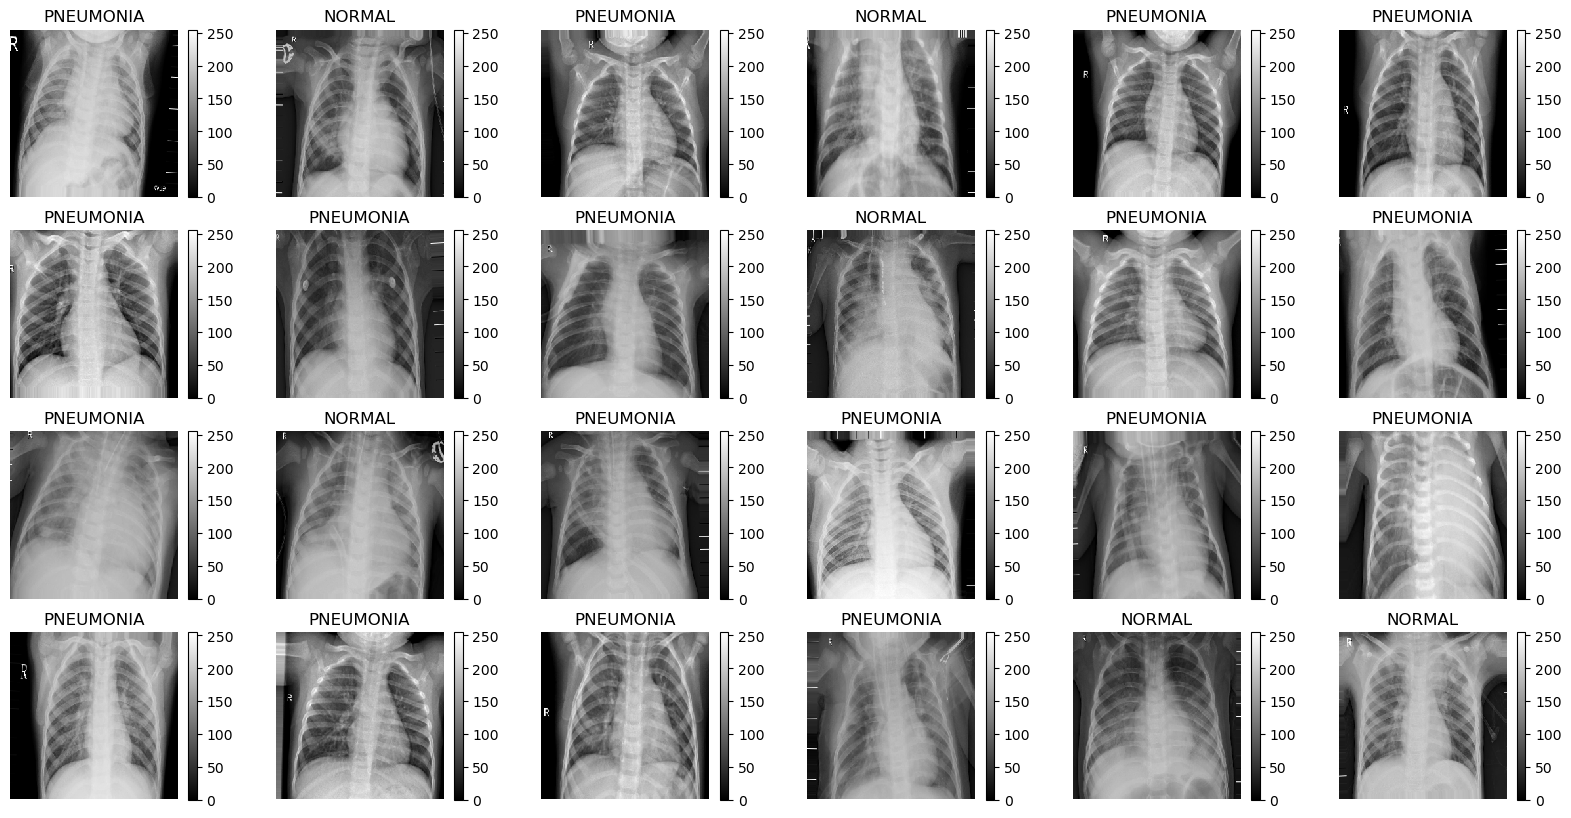

In [134]:
# Images and Labes from Training Set

plt.style.use('default')
fig=plt.figure(figsize=(20, 10))
columns = 6; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]        
        dic = {0:"NORMAL", 1:"PNEUMONIA"}
        plt.title(dic.get(Y_batch[0]))
        plt.axis("off")
        plt.imshow(array_to_img(X_train[i]), cmap=plt.cm.gray)
        plt.colorbar()
        fig.add_subplot
        break

The x-ray images of patients with pneumonia appear cloudier around the lung area. 

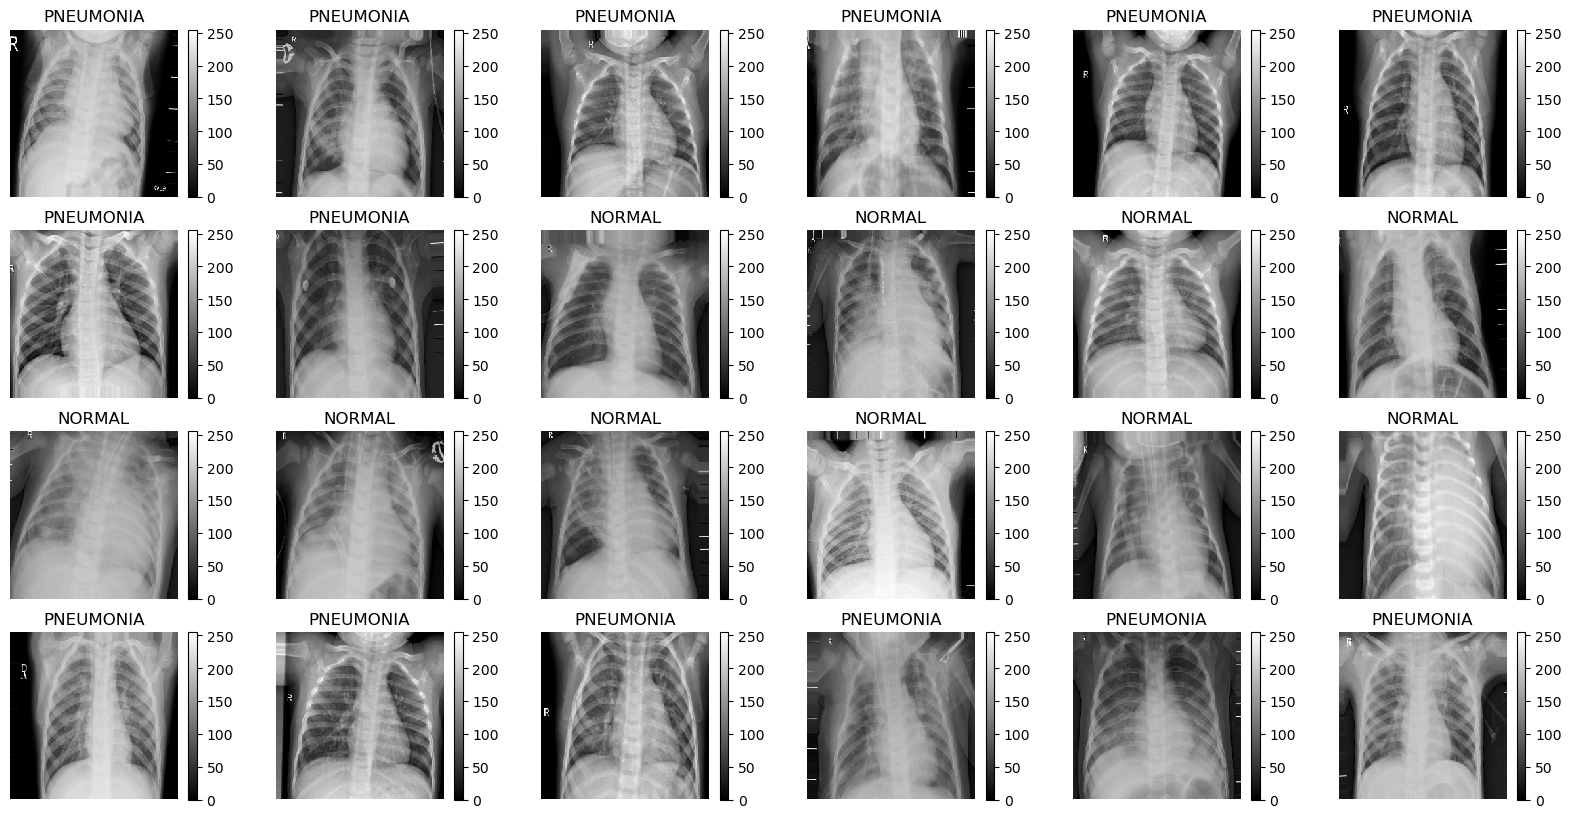

In [135]:
#Images and Labels from Validation Set

plt.style.use('default')
fig=plt.figure(figsize=(20, 10))
columns = 6; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    for X_batch, Y_batch in val_generator:
        image = X_batch[0]        
        dic = {0:"NORMAL", 1:"PNEUMONIA"}
        plt.title(dic.get(Y_batch[0]))
        plt.axis("off")
        plt.imshow(array_to_img(X_train[i]), cmap=plt.cm.gray)
        plt.colorbar()
        fig.add_subplot
        break

In [212]:
train_generator.filepaths

['../xrays/train/NORMAL/IM-0115-0001.jpeg',
 '../xrays/train/NORMAL/IM-0117-0001.jpeg',
 '../xrays/train/NORMAL/IM-0119-0001.jpeg',
 '../xrays/train/NORMAL/IM-0122-0001.jpeg',
 '../xrays/train/NORMAL/IM-0125-0001.jpeg',
 '../xrays/train/NORMAL/IM-0127-0001.jpeg',
 '../xrays/train/NORMAL/IM-0128-0001.jpeg',
 '../xrays/train/NORMAL/IM-0129-0001.jpeg',
 '../xrays/train/NORMAL/IM-0131-0001.jpeg',
 '../xrays/train/NORMAL/IM-0133-0001.jpeg',
 '../xrays/train/NORMAL/IM-0135-0001.jpeg',
 '../xrays/train/NORMAL/IM-0137-0001.jpeg',
 '../xrays/train/NORMAL/IM-0140-0001.jpeg',
 '../xrays/train/NORMAL/IM-0141-0001.jpeg',
 '../xrays/train/NORMAL/IM-0143-0001.jpeg',
 '../xrays/train/NORMAL/IM-0145-0001.jpeg',
 '../xrays/train/NORMAL/IM-0147-0001.jpeg',
 '../xrays/train/NORMAL/IM-0149-0001.jpeg',
 '../xrays/train/NORMAL/IM-0151-0001.jpeg',
 '../xrays/train/NORMAL/IM-0152-0001.jpeg',
 '../xrays/train/NORMAL/IM-0154-0001.jpeg',
 '../xrays/train/NORMAL/IM-0156-0001.jpeg',
 '../xrays/train/NORMAL/IM-0158-

In [287]:

# norm_files_path = [os.path.relpath(x) for x in os.listdir("../xrays/val/NORMAL/")]
# norm_files_path

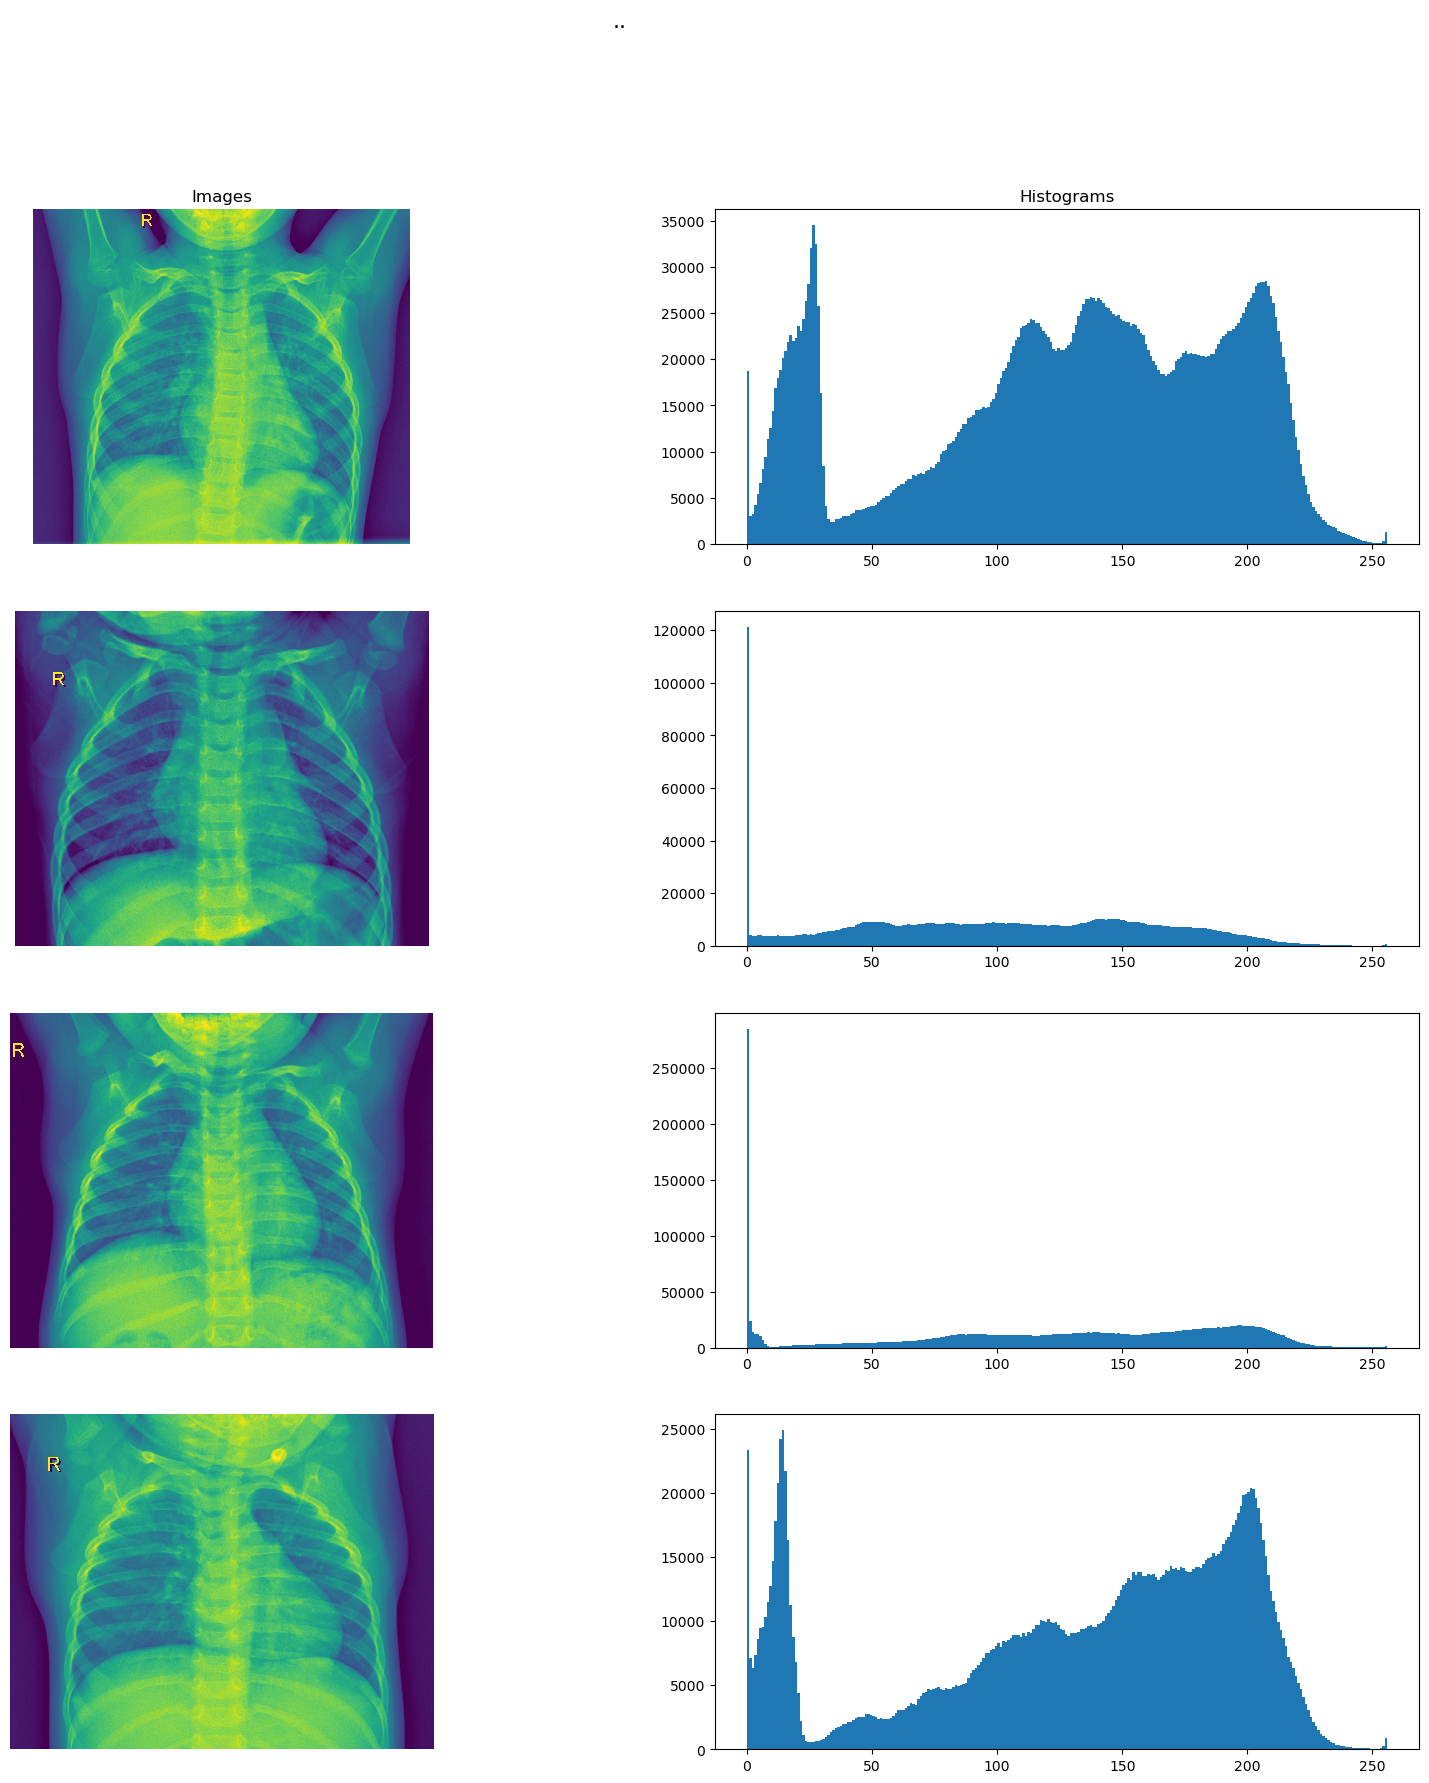

In [290]:

fig, ax = plt.subplots(4, 2, figsize=(20, 20))


for row, file_path in enumerate(train_generator.filepaths[:4]):
    image = plt.imread(file_path)
    ax[row, 0].imshow(image)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('..', size=16)
plt.show()

### Visualizing Class Counts

In [9]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [10]:
train_class = train_generator.classes
test_class = test_generator.classes
val_class = val_generator.classes


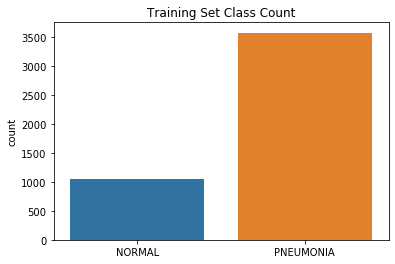

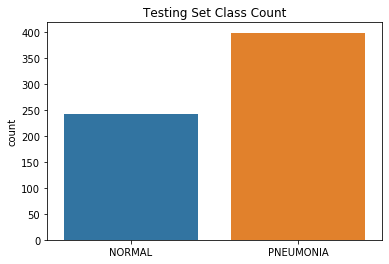

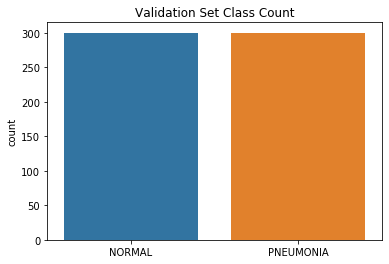

In [20]:
#Class Count in Training, Testing, and Validation sets

a = []
b = []
c = []

[a.append("NORMAL") if x == 0 else a.append("PNEUMONIA") for x in train_class]
[b.append("NORMAL") if x == 0 else b.append("PNEUMONIA") for x in test_class]
[c.append("NORMAL") if  x == 0 else c.append("PNEUMONIA") for x in val_class]

sns.countplot(a)
plt.title("Training Set Class Count")
plt.show()

sns.countplot(b)
plt.title("Testing Set Class Count")
plt.show()

sns.countplot(c)
plt.title("Validation Set Class Count")
plt.show()

The class imbalance in the training set is quite clear. In order to create a more balanced training set, we adjusted the class weights in our models.

## Dealing with Class Imbalance in Training Set

In [103]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight(class_weight = 'balanced',
                                                                               classes = np.unique(y_train),
                                                                               y = y_train))) 

In [136]:
class_weights

{0.0: 1.7777777777777777, 1.0: 0.6956521739130435}

These are the adjusted weights for our "0" or Normal class, and our "1" or Pneumonia class. As you can see, the weights applied to our Normal class is greater to account for the class imbalance.

## Modeling Process

## Model Q

In [104]:
modelq = models.Sequential()

modelq.add(Conv2D(32, (3, 3), kernel_initializer=he_uniform(), activation='relu', input_shape=(256, 256, 1)))
modelq.add(MaxPooling2D((2, 2)))

modelq.add(Conv2D(64, (3, 3), kernel_initializer=he_uniform(), activation='relu'))
modelq.add(MaxPooling2D((2, 2)))

modelq.add(Conv2D(128, (3, 3), kernel_initializer=he_uniform(), activation='relu'))
modelq.add(MaxPooling2D((2, 2)))

modelq.add(Conv2D(128, (3, 3), kernel_initializer=he_uniform(), activation='relu'))
modelq.add(MaxPooling2D((2, 2)))

modelq.add(Flatten())
modelq.add(Dropout(0.5))
modelq.add(Dense(512, kernel_initializer=he_uniform(), activation='relu'))
modelq.add(Dense(1, activation='sigmoid'))

modelq.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [140]:
#Compile model
compileparams = modelq.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=[Recall(), Precision(),'acc'])

In [106]:
from keras_tqdm import TQDMNotebookCallback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=10),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),TQDMNotebookCallback()]

In [108]:
#Fit the model to Training Set and Validate on Validation set
history_q = modelq.fit(train_generator, 
                    validation_data=(val_generator),
                    steps_per_epoch= 144,
                    epochs=5,
                    class_weight = class_weights,
#                        verbose=2,
#                        callbacks=callbacks
                    )

Epoch 1/5
144/144 [==============================] - 928s 6s/step - loss: 0.4855 - recall: 0.8713 - precision: 0.9156 - acc: 0.8381 - val_loss: 0.1067 - val_recall: 0.9933 - val_precision: 0.9430 - val_acc: 0.9667
Epoch 2/5
144/144 [==============================] - 603s 4s/step - loss: 0.1560 - recall: 0.9442 - precision: 0.9804 - acc: 0.9422 - val_loss: 0.1474 - val_recall: 0.9967 - val_precision: 0.8979 - val_acc: 0.9417
Epoch 3/5
144/144 [==============================] - 610s 4s/step - loss: 0.1301 - recall: 0.9524 - precision: 0.9851 - acc: 0.9520 - val_loss: 0.0662 - val_recall: 0.9967 - val_precision: 0.9614 - val_acc: 0.9783
Epoch 4/5
144/144 [==============================] - 655s 5s/step - loss: 0.1330 - recall: 0.9518 - precision: 0.9846 - acc: 0.9511 - val_loss: 0.2333 - val_recall: 1.0000 - val_precision: 0.8287 - val_acc: 0.8967
Epoch 5/5
144/144 [==============================] - 483s 3s/step - loss: 0.1307 - recall: 0.9507 - precision: 0.9837 - acc: 0.9496 - val_loss: 

In [ ]:
# save model to JSON
modelq_json = modelq.to_json()
with open("modelq.json", "w") as json_file:
    json_file.write(modelq_json)

# save weights to HDF5
modelq.save_weights("model_q_weights.h5")
print("Saved model to disk")

modelq.save('model_q.h5')  # creates a HDF5 file 'my_model.h5'
# del modelq  # deletes the existing model

### Plotting Validation Accuracy and Loss for Model Q

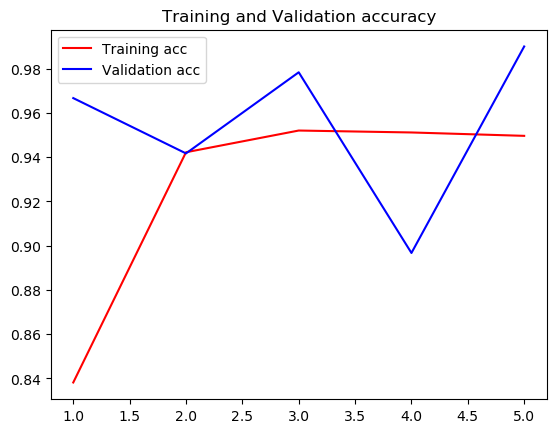

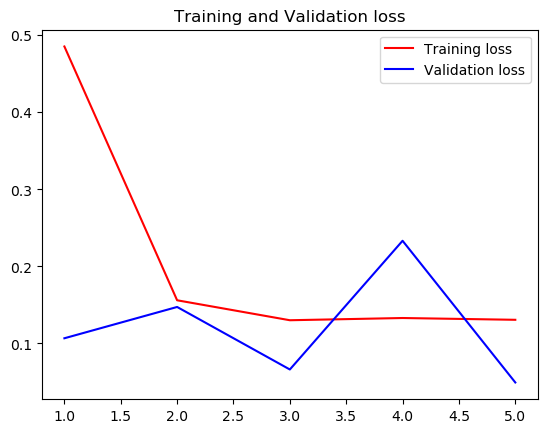

In [111]:
acc = history_q.history['acc']
val_acc = history_q.history['val_acc']
loss = history_q.history['loss']
val_loss = history_q.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

### Confusion Matrix for Model Q

**Predict on test set**

In [112]:
y_pred_q = modelq.predict(test_generator) > 0.5
y_true = test_generator.classes

[[161  81]
 [ 11 387]]


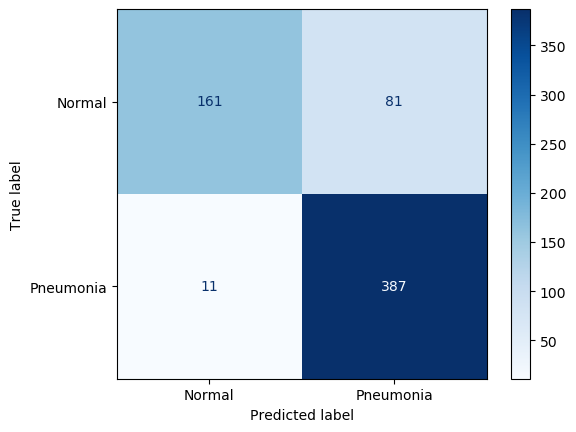

In [118]:
cm_q = confusion_matrix(test_generator.classes, y_pred_q)
print(cm_q)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_q, display_labels=["Normal", "Pneumonia"])

disp.plot(cmap='Blues')
plt.show()

## Viewing Missed Casses

In [171]:
missed_class = [idx for idx, y in enumerate(y_true) if y != y_pred_q[idx]]

In [271]:
lst = []
i = 0
while i < 350:
    lst.extend(next(test_generator))
    i += 1

700

In [272]:
missed_xray = [x for idx, x in enumerate(lst) if idx in missed_class]

Example 1

0.0


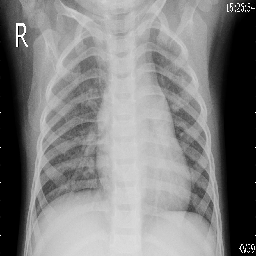

In [275]:
print(missed_xray[1][5])
array_to_img(missed_xray[0][5])

In [278]:
y_pred_q[28]

array([ True])

Example 2

1.0


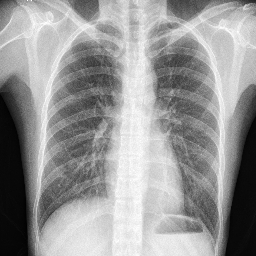

In [282]:
print(missed_xray[1][30])
array_to_img(missed_xray[0][30])

In [285]:
y_pred_q[30]

array([False])

### Evaluating Model Q's Performance on Test Set

In [119]:
score_q = modelq.evaluate(test_generator, verbose=1)
score_q

20/20 [==============================] - 20s 950ms/step - loss: 0.4072 - recall: 0.9724 - precision: 0.8269 - acc: 0.8562


[0.40720391273498535,
 0.9723618030548096,
 0.8269230723381042,
 0.856249988079071]

ROC Curve

In [ ]:
# y_val_prob = modelq.predict_proba(X_val)

# fpr, tpr, thresholds = roc_curve (y_val , y_val_prob)

# def plot_roc_curve(fpr,tpr): 
#     plt.plot(fpr,tpr)  
#     plt.xlabel('False Positive Rate') 
#     plt.ylabel('True Positive Rate') 
#     plt.show()    

    
# plot_roc_curve(fpr,tpr) 

In [ ]:
# #AUC Score 
# auc_score=roc_auc_score(y_val, y_val_prob) 
# auc_score

## Model R - Minor Changes

In [ ]:
modelr = models.Sequential()

modelr.add(Conv2D(32, (7, 7), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu', input_shape=(256, 256, 1)))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Conv2D(64, (3, 3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu'))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Conv2D(128, (3, 3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu'))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Conv2D(128, (3, 3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu'))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Conv2D(256, (3, 3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu'))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Conv2D(256, (3, 3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), padding = "same", activation='relu'))
modelr.add(MaxPooling2D((2, 2)))

modelr.add(Flatten())
modelr.add(Dropout(0.5))
modelr.add(Dense(512, kernel_initializer=he_uniform(), activation='relu'))
modelr.add(Dense(1, activation='sigmoid'))

modelr.summary()


In [ ]:
#Compile model
modelr.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=[Recall(), Precision(),'acc'])

In [ ]:
#Fit the model to Training Set and Validate on Validation set
history_r = modelr.fit(train_generator, 
                    validation_data=(val_generator),
                    steps_per_epoch= 144,
                    epochs=50,
                    class_weight = class_weights
                    )

### Plotting Validation Accuracy and Loss for Model R

In [ ]:
acc = history_r.history['acc']
val_acc = history_r.history['val_acc']
loss = history_r.history['loss']
val_loss = history_r.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

### Confusion Matrix for Model R

**Predict on test set**

In [ ]:
y_pred_r = modelr.predict(test_generator) > 0.5
y_true = test_generator.classes

In [ ]:
#Confusion Matrix
cm_r = confusion_matrix(y_true, y_pred_r)
print(cm_r)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')
plt.show()

In [ ]:
# print('Confusion Matrix\n')
# matrix = confusion_matrix(y_true, y_pred_r)
# print(matrix)


# disp = ConfusionMatrixDisplay(confusion_matrix=matrix)

# disp.plot(cmap='Blues')
# plt.show()

### Evaluating Model R's Performance on Test Set

In [ ]:
score_r = modelr.evaluate(test_generator, verbose=1)
score_r

## Model T

In [ ]:

modelt = models.Sequential()


modelt.add(Conv2D(16, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same',input_shape=(256, 256, 1)))
modelt.add(Conv2D(16, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(MaxPool2D((2, 2)))


modelt.add(SeparableConv2D(32, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(SeparableConv2D(32, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2, 2)))


modelt.add(SeparableConv2D(64, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(SeparableConv2D(64, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2, 2)))


modelt.add(SeparableConv2D(128, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(SeparableConv2D(128, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2, 2)))
modelt.add(Dropout(rate=0.2))


modelt.add(SeparableConv2D(256, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(SeparableConv2D(256, (3, 3), kernel_initializer=he_uniform(), activation='relu', padding='same'))
modelt.add(BatchNormalization())
modelt.add(MaxPool2D((2, 2)))
modelt.add(Dropout(0.2))


modelt.add(Flatten())
modelt.add(Dense(512, kernel_initializer=he_uniform(), activation='relu'))
modelt.add(Dropout(0.5))
modelt.add(Dense(128, kernel_initializer=he_uniform(), activation='relu'))
modelt.add(Dropout(0.5))
modelt.add(Dense(64, kernel_initializer=he_uniform(), activation='relu'))
modelt.add(Dropout(0.3))

modelt.add(Dense(1, activation='sigmoid'))
   
    
modelt.summary()

In [ ]:
#Compile model 
modelt.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=[Recall(), Precision(),'acc'])

#Fit the model to Training Set and Validate on Validation set
hist = modelt.fit(train_generator, 
                    validation_data=(val_generator),
                    steps_per_epoch= 144,
                    epochs=50,
                    class_weight = class_weights
                    )

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Confusion Matrix for Model T

In [ ]:
y_pred_t = modelt.predict(test_generator) > 0.5
y_true = test_generator.classes

print('Confusion Matrix\n')
cm_t = confusion_matrix(y_true, y_pred_t)
print(cm_t)


disp = ConfusionMatrixDisplay(confusion_matrix=cm_t)

disp.plot(cmap='Blues')
plt.show()

### Evaluating Model T's Performance on Test Set

In [ ]:
score_t = modelt.evaluate(test_generator, verbose=1)
score_t

## Model Z

In [ ]:
modelz = models.Sequential()

modelz.add(Conv2D(32, (7,7), kernel_initializer=he_uniform(), kernel_regularizer=l2(), activation='relu', input_shape=(256, 256, 1)))
modelz.add(MaxPooling2D(2,2))

modelz.add(Conv2D(32, (3,3), kernel_initializer=he_uniform(), kernel_regularizer=l2(), activation='relu'))
modelz.add(MaxPooling2D(2,2))

modelz.add(Conv2D(128,(3,3), kernel_initializer=he_uniform(), activation='relu'))
modelz.add(MaxPooling2D(2,2))

modelz.add(Conv2D(64,(3,3), kernel_initializer=he_uniform(), activation='relu'))
modelz.add(MaxPooling2D(2,2))

modelz.add(Conv2D(128,(3,3), kernel_initializer=he_uniform(), activation='relu'))
modelz.add(MaxPooling2D(2,2))

modelz.add(Conv2D(128,(3,3), kernel_initializer=he_uniform(), activation='relu'))
modelz.add(MaxPooling2D(2,2))
    

modelz.add(Flatten())
modelz.add(Dense(128, kernel_initializer=he_uniform(), activation='relu'))
modelz.add(Dropout(0.5))

modelz.add(Dense(1, activation='sigmoid'))

modelz.summary()


In [ ]:
#Compile model 
modelz.compile(Adam(lr=1e-6),loss = 'binary_crossentropy', metrics=[Recall(), Precision(),'acc'])

In [ ]:
#Fit the model to Training Set and Validate on Validation set
history_z = modelz.fit(train_generator,
                    validation_data =(val_generator),
                    epochs = 17,
                    steps_per_epoch=144
                    class_weight=class_weights,
                    verbose=2)

### Plotting Validation Accuracy and Loss for Model Z

In [ ]:
# Plotting Validation Accuracy and Loss for Model Z 
acc = history_z.history['acc']
val_acc = history_z.history['val_acc']
loss = history_z.history['loss']
val_loss = history_z.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

### Confustion Matrix for Model Z

In [ ]:
y_pred_z = modelz.predict(test_generator) > 0.5
y_true = test_generator.classes

print('Confusion Matrix\n')
cm_z = confusion_matrix(y_true, y_pred_z)
print(cm_z)


disp = ConfusionMatrixDisplay(confusion_matrix=cm_z)

disp.plot(cmap='Blues')
plt.show()

### Evaluating Model Z's Performance on Test Set

In [ ]:
score_z = modelz.evaluate(test_generator, verbose=0)
score_z

## Model Alex_net

In [ ]:
# Create callbacks for our model

# Create checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('model_alex_net.h5') 

# Create Custom callback
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.93) and (logs.get('loss')<= 0.3 and logs.get('val_loss') <= 0.3):
            if logs.get('accuracy') <= logs.get('val_accuracy'):
                self.model.stop_training = True
            else:
                self.model.stop_training = False
#             if(logs.get('accuracy') > 0.94 and logs.get('val_accuracy') > 0.94) and (logs.get('loss')<= 0.3 and logs.get('val_loss') <= 0.3):

custom_cb = CustomCallback()

In [ ]:
# Define alexNet model


model_alex_net = tf.keras.models.Sequential([
     # 1st conv layer                                        
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,1),
                           padding='valid'),
    tf.keras.layers.BatchNormalization(),
    # Max pooling
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    
    # # Dropout to prevent overfit
    # tf.keras.layers.Dropout(0.5),

    # 2nd conv layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),

    # Max pooling
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'),

    # # Dropout to prevent overfit
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    # 3rd conv layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    # 4th Conv layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    # 5th Conv layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    # Max Pooling
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    # Dropout to prevent overfit
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    # # Dropout to prevent overfit
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # Dropout to prevent overfit
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Look at summary of our model
model_alex_net.summary()

In [ ]:
model_alex_net.compile(loss='binary_crossentropy', optimizer =Adam(lr=1e-6), metrics=['accuracy', Recall()])

In [ ]:
hist = model_alex_net.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 32,
    class_weight=class_weights,
    callbacks=[custom_cb, checkpoint_cb]
)

In [ ]:
print('Loss of the model is - ', model_alex_net.evaluate(X_val, y_val)[0])
print('Accuracy of the model is - ', model_alex_net.evaluate(X_val, y_val)[1]*100, '%')

In [ ]:
predict = model_alex_net.predict_classes(X_test)
predict = predict.reshape(1, -1)[0]
predict

In [ ]:
predict_test = model_alex_net.predict_classes(X_test)
predict_test = predict.reshape(1, -1)[0]
predict_test

In [ ]:
print(classification_report(y_val, predict, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
# print(classification_report(y_test, predict_test, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
print('Confusion Matrix\n')
matrix = confusion_matrix(y_test, predict)
print(matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix)

disp.plot(cmap='Blues')
plt.show()

In [ ]:
correct = np.nonzero(predict == y_val)[0]
incorrect = np.nonzero(predict != y_val)[0]
print(len(correct), len(incorrect))

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_val[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {}\nActual Class {}".format(predict[c], y_val[c]))
    plt.tight_layout()
    i += 1

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_val[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {}\nActual Class {}".format(predict[c], y_val[c]))
    plt.tight_layout()